In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Tue Jan 16 21:42:56 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   52C    P0   214W / 300W |   6807MiB / 80994MiB |     64%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.spiral_prior import Prior
from model.latent.swae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 0.0
latent 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train01.16-10/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


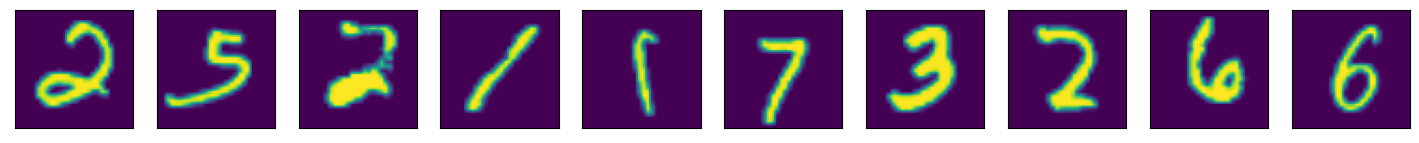

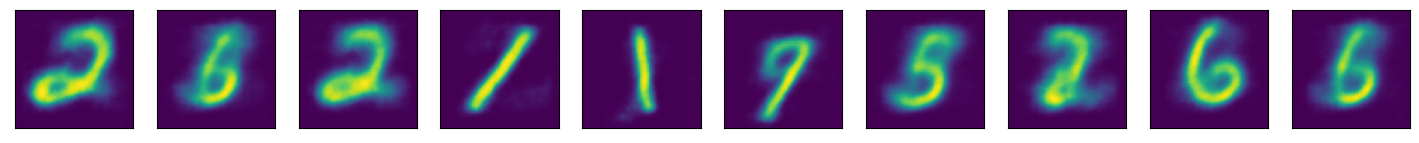

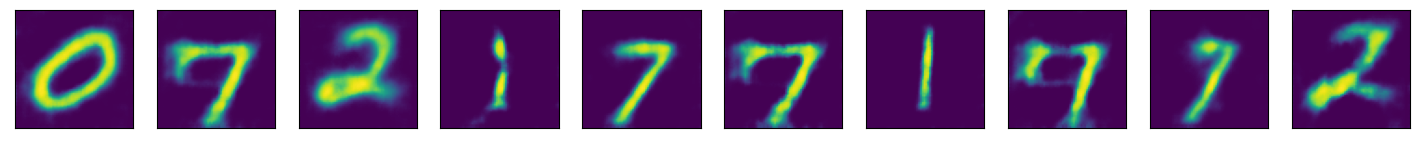

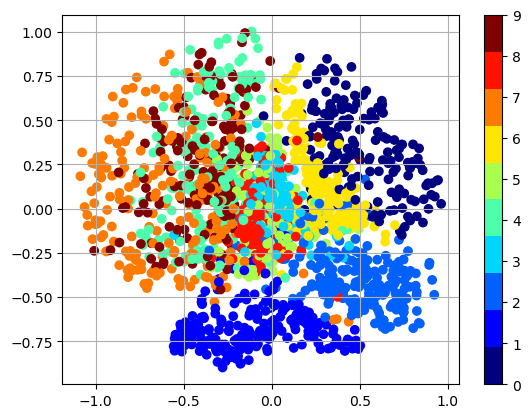

2001
swae_loss 0.0023028260678984226
recon_loss 0.13843510895967484
2002
swae_loss 0.001986448606476188
recon_loss 0.1439942091703415
2003
swae_loss 0.002629896893631667
recon_loss 0.13973162919282914
2004
swae_loss 0.0020025559701025487
recon_loss 0.14490295052528382
2005
swae_loss 0.0023328115814365445
recon_loss 0.1346462309360504
2006
swae_loss 0.001658109447453171
recon_loss 0.1356770306825638
2007
swae_loss 0.002311277063563466
recon_loss 0.1439906284213066
2008
swae_loss 0.0021439578966237606
recon_loss 0.1356246918439865
2009
swae_loss 0.002170023159123957
recon_loss 0.13462457358837127
2010
swae_loss 0.002335351996589452
recon_loss 0.14025920480489731
2011
swae_loss 0.001864922314416617
recon_loss 0.14479668885469438
2012
swae_loss 0.001959098386578262
recon_loss 0.13199045658111572
2013
swae_loss 0.0021087486646138133
recon_loss 0.13714348375797272
2014
swae_loss 0.0018189106252975763
recon_loss 0.13274477869272233
2015
swae_loss 0.0020824923703912646
recon_loss 0.13407050669

swae_loss 0.0020823449245654046
recon_loss 0.13417984843254088
2124
swae_loss 0.002476746740285307
recon_loss 0.13994651436805725
2125
swae_loss 0.0019624804961495103
recon_loss 0.13325758129358292
2126
swae_loss 0.0017065402702428401
recon_loss 0.13305452167987825
2127
swae_loss 0.00230613574385643
recon_loss 0.13825580179691316
2128
swae_loss 0.0020779203157871963
recon_loss 0.14429925084114076
2129
swae_loss 0.0024898061994463204
recon_loss 0.13273811042308808
2130
swae_loss 0.0022440230241045356
recon_loss 0.12934013530611993
2131
swae_loss 0.001978930609766394
recon_loss 0.13493829667568208
2132
swae_loss 0.0023070874274708332
recon_loss 0.14092739671468735
2133
swae_loss 0.0021420112112537026
recon_loss 0.1288388893008232
2134
swae_loss 0.002737846353556961
recon_loss 0.13073425143957138
2135
swae_loss 0.00216277961153537
recon_loss 0.13058316633105277
2136
swae_loss 0.0025665017892606556
recon_loss 0.1349806383252144
2137
swae_loss 0.002480230457149446
recon_loss 0.1347387328743

swae_loss 0.001981499302200973
recon_loss 0.13418045341968537
2246
swae_loss 0.002148144505918026
recon_loss 0.1396474912762642
2247
swae_loss 0.0016977525549009443
recon_loss 0.14015093296766282
2248
swae_loss 0.002276183234062046
recon_loss 0.13600657880306244
2249
swae_loss 0.002061804395634681
recon_loss 0.13344805389642717
2250
swae_loss 0.0015658458461984992
recon_loss 0.13882385939359665
2251
swae_loss 0.0018299901392310857
recon_loss 0.1383882761001587
2252
swae_loss 0.0016077212174423039
recon_loss 0.1326449990272522
2253
swae_loss 0.0019404911901801825
recon_loss 0.13515992164611818
2254
swae_loss 0.0017493674997240305
recon_loss 0.13347727954387664
2255
swae_loss 0.0015386184328235685
recon_loss 0.13735893815755845
2256
swae_loss 0.002013233699835837
recon_loss 0.1307348847389221
2257
swae_loss 0.0018391378689557314
recon_loss 0.13753781765699385
2258
swae_loss 0.0021675159223377705
recon_loss 0.13684381991624833
2259
swae_loss 0.0015550677082501352
recon_loss 0.131194844841

swae_loss 0.0015541185974143445
recon_loss 0.13161375522613525
2368
swae_loss 0.002004674053750932
recon_loss 0.13102422654628754
2369
swae_loss 0.002158317598514259
recon_loss 0.1352618604898453
2370
swae_loss 0.00207166209584102
recon_loss 0.12699726969003677
2371
swae_loss 0.001817484071943909
recon_loss 0.13723834753036498
2372
swae_loss 0.0023923216969706116
recon_loss 0.14130693674087524
2373
swae_loss 0.002271291217766702
recon_loss 0.13833327293395997
2374
swae_loss 0.0018713563797064126
recon_loss 0.1260338045656681
2375
swae_loss 0.0019476340734399856
recon_loss 0.1416675180196762
2376
swae_loss 0.0016628321725875139
recon_loss 0.13058911859989167
2377
swae_loss 0.0018756852019578218
recon_loss 0.13286273926496506
2378
swae_loss 0.0017376242321915925
recon_loss 0.12947504296898843
2379
swae_loss 0.0015006986563093961
recon_loss 0.12927410155534744
2380
swae_loss 0.001652084686793387
recon_loss 0.13805227726697922
2381
swae_loss 0.001659375778399408
recon_loss 0.13207052201032

swae_loss 0.0018691830220632256
recon_loss 0.13631631880998613
2490
swae_loss 0.0019376107840798796
recon_loss 0.13372999280691147
2491
swae_loss 0.0016290470375679433
recon_loss 0.13002789914608
2492
swae_loss 0.0021299985819496214
recon_loss 0.13741260319948195
2493
swae_loss 0.0014962013927288353
recon_loss 0.13213212341070174
2494
swae_loss 0.0018459351500496267
recon_loss 0.134376859664917
2495
swae_loss 0.0017899095080792903
recon_loss 0.13291980177164078
2496
swae_loss 0.0016529711079783737
recon_loss 0.13674487471580504
2497
swae_loss 0.0018910910584963858
recon_loss 0.13139232248067856
2498
swae_loss 0.0013964659185148776
recon_loss 0.1344955801963806
2499
swae_loss 0.0016438954509794713
recon_loss 0.13329130113124849
2500
swae_loss 0.0013993230415508151
recon_loss 0.12937587648630142
2501
swae_loss 0.0013931386638432741
recon_loss 0.13226971924304962
2502
swae_loss 0.0017362620332278312
recon_loss 0.13208163678646087
2503
swae_loss 0.0016647569951601326
recon_loss 0.132753923

swae_loss 0.0019285262213088572
recon_loss 0.14076178520917892
2612
swae_loss 0.0018651997088454664
recon_loss 0.13190935254096986
2613
swae_loss 0.0017861662316136062
recon_loss 0.13551977276802063
2614
swae_loss 0.001945821347180754
recon_loss 0.13329004049301146
2615
swae_loss 0.0016972299898043274
recon_loss 0.13189020454883577
2616
swae_loss 0.002178596274461597
recon_loss 0.13140533417463302
2617
swae_loss 0.0017932070652022958
recon_loss 0.13017591387033461
2618
swae_loss 0.0016244908038061112
recon_loss 0.13310939818620682
2619
swae_loss 0.0019015728845261036
recon_loss 0.12717394977808
2620
swae_loss 0.0015880341990850866
recon_loss 0.13221083283424379
2621
swae_loss 0.0016990761505439878
recon_loss 0.12802230566740036
2622
swae_loss 0.0018621895462274552
recon_loss 0.13375457972288132
2623
swae_loss 0.0014078375301323832
recon_loss 0.13069768249988556
2624
swae_loss 0.0021616287413053215
recon_loss 0.13714012503623962
2625
swae_loss 0.0016840480733662845
recon_loss 0.13132929

swae_loss 0.001669338857755065
recon_loss 0.13394383192062378
2734
swae_loss 0.0025701264850795267
recon_loss 0.13299443423748017
2735
swae_loss 0.0015758966095745564
recon_loss 0.13532487899065018
2736
swae_loss 0.0023355338023975493
recon_loss 0.13114749789237976
2737
swae_loss 0.0017971749999560415
recon_loss 0.12819951251149178
2738
swae_loss 0.002049944910686463
recon_loss 0.13361561596393584
2739
swae_loss 0.002196183509659022
recon_loss 0.13635627031326295
2740
swae_loss 0.001779515645466745
recon_loss 0.12977535873651505
2741
swae_loss 0.002119771472644061
recon_loss 0.13433297127485275
2742
swae_loss 0.0016711673932150006
recon_loss 0.1343787282705307
2743
swae_loss 0.0017199414898641408
recon_loss 0.13278907537460327
2744
swae_loss 0.001786063564941287
recon_loss 0.13586597442626952
2745
swae_loss 0.001686658925609663
recon_loss 0.12604058608412744
2746
swae_loss 0.0019888312323018908
recon_loss 0.13505183756351472
2747
swae_loss 0.001679302309639752
recon_loss 0.130995751917

swae_loss 0.002548207947984338
recon_loss 0.1276713602244854
2856
swae_loss 0.0020057640038430693
recon_loss 0.13725702613592147
2857
swae_loss 0.0019694235525093973
recon_loss 0.1281403824687004
2858
swae_loss 0.0017617094796150922
recon_loss 0.12976332902908325
2859
swae_loss 0.0020326829398982227
recon_loss 0.12935954034328462
2860
swae_loss 0.0018684332142584025
recon_loss 0.12980797290802001
2861
swae_loss 0.002014709613285959
recon_loss 0.13271041959524155
2862
swae_loss 0.0022946953075006606
recon_loss 0.13044184744358062
2863
swae_loss 0.002001963020302355
recon_loss 0.13564519584178925
2864
swae_loss 0.002370838657952845
recon_loss 0.13298131823539733
2865
swae_loss 0.0016540144104510545
recon_loss 0.12950517237186432
2866
swae_loss 0.0018914585816673934
recon_loss 0.1333730086684227
2867
swae_loss 0.0020405166316777466
recon_loss 0.13466466218233109
2868
swae_loss 0.0020854709786362947
recon_loss 0.13966301530599595
2869
swae_loss 0.0016972398501820863
recon_loss 0.1320787504

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=len(data['x']))

            # Backward
            loss = 0
            for key in data.keys():
                if 'swae_loss' in key:
                    loss = loss + data[key] * 10
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=len(data['x']))
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        